In [3]:
pwd


'D:\\labdata\\MOCAP\\recordings_copy\\受試者10\\recording_20241204_100047'

In [4]:
%cd D:\\labdata\\MOCAP\\recordings_copy\\受試者11\\

D:\labdata\MOCAP\recordings_copy\受試者11


In [2]:
import sys
print(sys.executable)


C:\Users\user\Anaconda3\python.exe


In [8]:
##做內插 全體版
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os


def interpolate_landmarks(input_file, output_file):
    df = pd.read_csv(input_file, header=None, names=["frame", "landmark", "x", "y"])
    df.replace('no detection', np.nan, inplace=True)
    df[['landmark', 'x', 'y']] = df[['landmark', 'x', 'y']].apply(pd.to_numeric, errors='coerce')
    all_frames = df['frame'].unique()
    interpolated_data = []
    for frame in all_frames:
        current_frame_data = df[df['frame'] == frame]
        if current_frame_data.empty:
            continue  
        if 'no detection' in current_frame_data.values:
            for landmark in range(0, 17):
                interpolated_data.append([frame, landmark, np.nan, np.nan])
            continue
        for landmark in range(0, 17):
            landmark_data = current_frame_data[current_frame_data['landmark'] == landmark]

            if landmark_data.empty:
                prev_frame_data = df[(df['frame'] < frame) & (df['landmark'] == landmark)].iloc[-1] if not df[(df['frame'] < frame) & (df['landmark'] == landmark)].empty else None
                next_frame_data = df[(df['frame'] > frame) & (df['landmark'] == landmark)].iloc[0] if not df[(df['frame'] > frame) & (df['landmark'] == landmark)].empty else None
                
                if prev_frame_data is not None and next_frame_data is not None:
                    interp_x = (prev_frame_data['x'] + next_frame_data['x']) / 2
                    interp_y = (prev_frame_data['y'] + next_frame_data['y']) / 2
                elif prev_frame_data is not None:
                    interp_x = prev_frame_data['x']
                    interp_y = prev_frame_data['y']
                elif next_frame_data is not None:
                    interp_x = next_frame_data['x']
                    interp_y = next_frame_data['y']
                else:
                    interp_x = interp_y = interp_z = np.nan
                
                interpolated_data.append([frame, landmark, interp_x, interp_y])
            else:
                landmark_row = landmark_data.iloc[0]
                interpolated_data.append([frame, landmark_row['landmark'], landmark_row['x'], landmark_row['y']])

    output_df = pd.DataFrame(interpolated_data, columns=["frame", "landmark", "x", "y"])
    output_df.to_csv(output_file, index=False, header=False)
    print(f"已完成內插並將結果儲存至 {output_file}")

def load_yolo_data(filename):
    # 讀取 YOLO 資料
    data = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                values = [float(x) for x in line.strip().split(',')]
                if len(values) == 5:  # YOLO 的資料應有 5 個欄位
                    data.append(values)
            except ValueError:
                print(f"Skipping line: {line}")
    return np.array(data)

def interpolate_missing_detections(yolo_data):
    frames = yolo_data[:, 0]
    x_center = yolo_data[:, 1]
    y_center = yolo_data[:, 2]
    widths = yolo_data[:, 3]
    heights = yolo_data[:, 4]

    # 找到有效檢測的幀索引
    valid_indices = np.where((x_center != -1) & (y_center != -1) & (widths != -1) & (heights != -1))[0]

    # 確保所有幀都有值
    all_frames = np.arange(int(frames.min()), int(frames.max()) + 1)

    # 使用有效檢測的幀進行插值
    interp_x_center = interp1d(frames[valid_indices], x_center[valid_indices], kind='linear', fill_value="extrapolate")
    interp_y_center = interp1d(frames[valid_indices], y_center[valid_indices], kind='linear', fill_value="extrapolate")
    interp_widths = interp1d(frames[valid_indices], widths[valid_indices], kind='linear', fill_value="extrapolate")
    interp_heights = interp1d(frames[valid_indices], heights[valid_indices], kind='linear', fill_value="extrapolate")

    # 對於所有幀進行插值
    interpolated_x_center = interp_x_center(all_frames)
    interpolated_y_center = interp_y_center(all_frames)
    interpolated_widths = interp_widths(all_frames)
    interpolated_heights = interp_heights(all_frames)

    # 組合內插後的資料
    interpolated_data = np.column_stack((all_frames, interpolated_x_center, interpolated_y_center, interpolated_widths, interpolated_heights))
    return interpolated_data

def interpolate_mediapipe(yolo_frames, mediapipe_data, landmarks):
    interpolated_data = []
    # original_data = []
    
    for landmark in landmarks:
        # 獲取該 landmark 的座標
        group = mediapipe_data[mediapipe_data[:, 1] == landmark]
        frames = group[:, 0]
        x_coords = group[:, 2]
        y_coords = group[:, 3]

        mediapipe_first_frame = frames[0]
        mediapipe_last_frame = frames[-1]

        aligned_frames = np.linspace(yolo_frames[0], yolo_frames[-1], len(frames))
        interp_x = interp1d(aligned_frames, x_coords, kind='linear')
        interp_y = interp1d(aligned_frames, y_coords, kind='linear')
        interp_x = interp1d(aligned_frames, x_coords, kind='linear', fill_value="extrapolate")
        interp_y = interp1d(aligned_frames, y_coords, kind='linear', fill_value="extrapolate")
        interpolated_x = interp_x(yolo_frames)
        interpolated_y = interp_y(yolo_frames)
        for i, frame in enumerate(yolo_frames):
            interpolated_data.append([frame, landmark, interpolated_x[i], interpolated_y[i]])
    return interpolated_data

def process_yolo_files(root_dir):
    for dirpath, _, filenames in os.walk(root_dir):
        if '棋盤' in dirpath:
            continue
        
        if 'yolo_skeleton_coordinates.txt' in filenames and 'yolo_coordinates_new.txt' in filenames:
            skeleton_file = os.path.join(dirpath, 'yolo_skeleton_coordinates.txt')
            yolo_file = os.path.join(dirpath, 'yolo_coordinates_new.txt')
            
            # 第一階段: 插值 yolo_skeleton_coordinates.txt
            skeleton_output_file = os.path.join(dirpath, 'yolo_skeleton_coordinates_vision1_interp.txt')
            interpolate_landmarks(skeleton_file, skeleton_output_file)
            
            # 第二階段: 插值 yolo_coordinates_new.txt
            yolo_data = load_yolo_data(yolo_file)
            interpolated_yolo_data = interpolate_missing_detections(yolo_data)
            yolo_interpolated_file = os.path.join(dirpath, 'yolo_coordinates_interpolated.txt')
            np.savetxt(yolo_interpolated_file, interpolated_yolo_data, delimiter=',', fmt='%d,%.8f,%.8f,%.8f,%.8f')
            print(f"Processed and saved: {yolo_interpolated_file}")
            
            # 第三階段: 再次插值 skeleton
            yolo_data = np.loadtxt(yolo_interpolated_file, delimiter=',')
            yolo_frames = yolo_data[:, 0]  # frame numbers
            mediapipe_data = np.loadtxt(skeleton_output_file, delimiter=',')
            landmarks = np.unique(mediapipe_data[:, 1])  # unique landmark numbers
            interpolated_data = interpolate_mediapipe(yolo_frames, mediapipe_data, landmarks)
            
            with open(skeleton_output_file, 'w') as f:
                for entry in interpolated_data:
                    f.write(f"{int(entry[0])},{int(entry[1])},{int(entry[2])},{int(entry[3])}\n")
            print(f"Processed and saved: {skeleton_output_file}")

# 設定要遍歷的根目錄
root_directory = "D:\\labdata\\MOCAP\\recordings_copy"  # 請替換為實際的根目錄
process_yolo_files(root_directory)




已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者10\recording_20241204_100047\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者10\recording_20241204_100047\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者10\recording_20241204_100047\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者10\recording_20241204_100314\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者10\recording_20241204_100314\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者10\recording_20241204_100314\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者10\recording_20241204_100527\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者10\recording_20241204_100527\yolo_coordinates_interpolated.txt
Processed

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者21\recording_20241206_134557\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者21\recording_20241206_134557\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者21\recording_20241206_134557\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者21\recording_20241206_134731\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者21\recording_20241206_134731\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者21\recording_20241206_134731\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者21\recording_20241206_134923\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者21\recording_20241206_134923\yolo_coordinates_interpolated.txt
Processed

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者26\recording_20241206_163826\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者26\recording_20241206_163826\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者26\recording_20241206_163826\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者26\recording_20241206_164034\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者26\recording_20241206_164034\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者26\recording_20241206_164034\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者26\recording_20241206_164246\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者26\recording_20241206_164246\yolo_coordinates_interpolated.txt
Processed

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者30\recording_20241209_112743\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者30\recording_20241209_112743\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者30\recording_20241209_112743\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者31\recording_20241209_113214\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者31\recording_20241209_113214\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者31\recording_20241209_113214\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者31\recording_20241209_113321\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者31\recording_20241209_113321\yolo_coordinates_interpolated.txt
Processed

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者32\recording_20241210_101040\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者32\recording_20241210_101040\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者32\recording_20241210_101040\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者32\recording_20241210_101116\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者32\recording_20241210_101116\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者32\recording_20241210_101116\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者32\recording_20241210_101203\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者32\recording_20241210_101203\yolo_coordinates_interpolated.txt
Processed

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者33\recording_20241210_103326\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者33\recording_20241210_103326\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者33\recording_20241210_103326\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者33\recording_20241210_103501\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者33\recording_20241210_103501\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者33\recording_20241210_103501\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者33\recording_20241210_103606\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者33\recording_20241210_103606\yolo_coordinates_interpolated.txt
Processed

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者52\recording_20241223_175915\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者52\recording_20241223_175915\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者52\recording_20241223_175915\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者52\recording_20241223_180026\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者52\recording_20241223_180026\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者52\recording_20241223_180026\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者52\recording_20241223_180202\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者52\recording_20241223_180202\yolo_coordinates_interpolated.txt
Processed

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者93\recording_20250114_170043\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者93\recording_20250114_170043\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者93\recording_20250114_170043\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者93\recording_20250114_170235\yolo_skeleton_coordinates_vision1_interp.txt
Skipping line: 257,no detection

Skipping line: 484,no detection

Skipping line: 926,no detection

Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者93\recording_20250114_170235\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\受試者93\recording_20250114_170235\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\受試者93\recording_20250114_170331\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdat

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\景倫7\recording_20241127_104623\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\景倫7\recording_20241127_104623\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\景倫7\recording_20241127_104623\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\景倫7\recording_20241127_105016\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\景倫7\recording_20241127_105016\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\景倫7\recording_20241127_105016\yolo_skeleton_coordinates_vision1_interp.txt


C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\曉慶8\recording_20241127_103227\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\曉慶8\recording_20241127_103227\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\曉慶8\recording_20241127_103227\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\曉慶8\recording_20241127_103529\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\曉慶8\recording_20241127_103529\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\曉慶8\recording_20241127_103529\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\曉慶8\recording_20241127_104145\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\曉慶8\recording_20241127_104145\yolo_coordinates_interpolated.txt
Processed and saved: D:\l

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\柏翰學長9\recording_20241203_132124\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\柏翰學長9\recording_20241203_132124\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\柏翰學長9\recording_20241203_132124\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\柏翰學長9\recording_20241203_132709\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\柏翰學長9\recording_20241203_132709\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\柏翰學長9\recording_20241203_132709\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\柏翰學長9\recording_20241203_133011\yolo_skeleton_coordinates_vision1_interp.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\柏翰學長9\recording_20241203_133011\yolo_coordinates_interpolated.txt
Processed

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\scipy\interpolate\_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\老師6\recording_20241125_165017\yolo_skeleton_coordinates_vision1_interp.txt
Skipping line: 215,no detection

Skipping line: 677,no detection

Skipping line: 1242,no detection

Processed and saved: D:\labdata\MOCAP\recordings_copy\老師6\recording_20241125_165017\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\老師6\recording_20241125_165017\yolo_skeleton_coordinates_vision1_interp.txt
已完成內插並將結果儲存至 D:\labdata\MOCAP\recordings_copy\老師6\recording_20241125_165126\yolo_skeleton_coordinates_vision1_interp.txt
Skipping line: 101,no detection

Skipping line: 131,no detection

Skipping line: 513,no detection

Skipping line: 670,no detection

Skipping line: 714,no detection

Skipping line: 830,no detection

Skipping line: 1008,no detection

Processed and saved: D:\labdata\MOCAP\recordings_copy\老師6\recording_20241125_165126\yolo_coordinates_interpolated.txt
Processed and saved: D:\labdata\MOCAP\recordings_copy\老師6\rec

In [5]:
###寫一個把三次內插整合在一起的
#第一次:把mediapipe裡面沒偵測到的先內插補植
#第二次:把槓端的沒偵測到的內插補植
#第三次:把mediapipe資料的長度對齊yolo的長度

###處理mediapipe資料的no detection
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


def interpolate_landmarks(input_file, output_file):
    # 讀取TXT文件
    df = pd.read_csv(input_file, header=None, names=["frame", "landmark", "x", "y"])

    # 將 'no detection' 替換為 NaN
    df.replace('no detection', np.nan, inplace=True)

    # 將需要進行插值的列轉換為數值型
    df[['landmark', 'x', 'y']] = df[['landmark', 'x', 'y']].apply(pd.to_numeric, errors='coerce')

    # 取得所有 frame 的範圍
    all_frames = df['frame'].unique()

    # 準備一個空的列表來儲存最終結果
    interpolated_data = []

    # 對每個 frame 進行處理
    for frame in all_frames:
        current_frame_data = df[df['frame'] == frame]

        # 儲存該 frame 的所有資料
        if current_frame_data.empty:
            continue  # 如果沒有資料則跳過

        if 'no detection' in current_frame_data.values:
            # 如果有 'no detection' 的標記，儲存該行
            for landmark in range(0, 17):
                interpolated_data.append([frame, landmark, np.nan, np.nan])
            continue

        # 對 landmarks 11 到 24 進行插值
        for landmark in range(0, 17):
            landmark_data = current_frame_data[current_frame_data['landmark'] == landmark]

            if landmark_data.empty:
                # 如果當前 landmark 沒有資料，則進行內插
                prev_frame_data = df[(df['frame'] < frame) & (df['landmark'] == landmark)].iloc[-1] if not df[(df['frame'] < frame) & (df['landmark'] == landmark)].empty else None
                next_frame_data = df[(df['frame'] > frame) & (df['landmark'] == landmark)].iloc[0] if not df[(df['frame'] > frame) & (df['landmark'] == landmark)].empty else None
                
                if prev_frame_data is not None and next_frame_data is not None:
                    interp_x = (prev_frame_data['x'] + next_frame_data['x']) / 2
                    interp_y = (prev_frame_data['y'] + next_frame_data['y']) / 2
#                     interp_z = (prev_frame_data['z'] + next_frame_data['z']) / 2
                elif prev_frame_data is not None:
                    interp_x = prev_frame_data['x']
                    interp_y = prev_frame_data['y']
#                     interp_z = prev_frame_data['z']
                elif next_frame_data is not None:
                    interp_x = next_frame_data['x']
                    interp_y = next_frame_data['y']
#                     interp_z = next_frame_data['z']
                else:
                    interp_x = interp_y = interp_z = np.nan
                
                interpolated_data.append([frame, landmark, interp_x, interp_y])
            else:
                # 如果有資料，則直接取用
                landmark_row = landmark_data.iloc[0]
                interpolated_data.append([frame, landmark_row['landmark'], landmark_row['x'], landmark_row['y']])

    # 將結果轉換為 DataFrame
    output_df = pd.DataFrame(interpolated_data, columns=["frame", "landmark", "x", "y"])

    # 將結果保存到新的TXT文件，不輸出索引與標題行
    output_df.to_csv(output_file, index=False, header=False)

    print(f"已完成內插並將結果儲存至 {output_file}")

# 設定要處理的文件
input_files = ['yolo_skeleton_coordinates_vision1.txt']  # 請替換為你的輸入檔名
output_files = ['yolo_skeleton_coordinates_interp_vision1.txt']  # 對應的輸出檔名

# 對每個文件進行內插處理
for input_file, output_file in zip(input_files, output_files):
    interpolate_landmarks(input_file, output_file)

####處理yolo的no detection並且內插


def load_yolo_data(filename):
    # 讀取 YOLO 資料
    data = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                values = [float(x) for x in line.strip().split(',')]
                if len(values) == 5:  # YOLO 的資料應有 5 個欄位
                    data.append(values)
            except ValueError:
                print(f"Skipping line: {line}")
    return np.array(data)


def interpolate_missing_detections(yolo_data):
    frames = yolo_data[:, 0]
    x_center = yolo_data[:, 1]
    y_center = yolo_data[:, 2]
    widths = yolo_data[:, 3]
    heights = yolo_data[:, 4]

    # 找到有效檢測的幀索引
    valid_indices = np.where((x_center != -1) & (y_center != -1) & (widths != -1) & (heights != -1))[0]

    # 確保所有幀都有值
    all_frames = np.arange(int(frames.min()), int(frames.max()) + 1)

    # 使用有效檢測的幀進行插值
    interp_x_center = interp1d(frames[valid_indices], x_center[valid_indices], kind='linear', fill_value="extrapolate")
    interp_y_center = interp1d(frames[valid_indices], y_center[valid_indices], kind='linear', fill_value="extrapolate")
    interp_widths = interp1d(frames[valid_indices], widths[valid_indices], kind='linear', fill_value="extrapolate")
    interp_heights = interp1d(frames[valid_indices], heights[valid_indices], kind='linear', fill_value="extrapolate")

    # 對於所有幀進行插值
    interpolated_x_center = interp_x_center(all_frames)
    interpolated_y_center = interp_y_center(all_frames)
    interpolated_widths = interp_widths(all_frames)
    interpolated_heights = interp_heights(all_frames)

    # 組合內插後的資料
    interpolated_data = np.column_stack((all_frames, interpolated_x_center, interpolated_y_center, interpolated_widths, interpolated_heights))
    return interpolated_data

# 載入 YOLO 資料
yolo_data = load_yolo_data('yolo_coordinates_new.txt')

# 內插 YOLO 中的 "no detection" 資料
interpolated_yolo_data = interpolate_missing_detections(yolo_data)

# 將結果保存到新的檔案，第一列為整數，其他為浮點數
np.savetxt('yolo_coordinates_interpolated.txt', interpolated_yolo_data, delimiter=',', fmt='%d,%.8f,%.8f,%.8f,%.8f')

print("YOLO 'no detection' frames have been interpolated and saved to 'yolo_coordinates_interpolated.txt'.")

####這邊先把mediapipe資料內插成yolo的數量，因yolo資料量通常較長

%matplotlib inline      
# 讀取 YOLO 的資料
yolo_data = np.loadtxt('yolo_coordinates_interpolated.txt', delimiter=',')
yolo_frames = yolo_data[:, 0]  # frame numbers

# 讀取第一份 MediaPipe 的資料
mediapipe_data_1 = np.loadtxt('yolo_skeleton_coordinates_interp_vision1.txt', delimiter=',')
landmarks_1 = np.unique(mediapipe_data_1[:, 1])  # unique landmark numbers

# 讀取第二份 MediaPipe 的資料
# mediapipe_data_2 = np.loadtxt('mediapipe_landmarks_2_1st_interp.txt', delimiter=',')
# landmarks_2 = np.unique(mediapipe_data_2[:, 1])  # unique landmark numbers

def interpolate_mediapipe(yolo_frames, mediapipe_data, landmarks):
    interpolated_data = []
    # original_data = []
    
    for landmark in landmarks:
        # 獲取該 landmark 的座標
        group = mediapipe_data[mediapipe_data[:, 1] == landmark]
        frames = group[:, 0]
        x_coords = group[:, 2]
        y_coords = group[:, 3]
#         z_coords = group[:, 4]

        # original_data.append((frames, x_coords, y_coords, z_coords))


        # 將 MediaPipe 的第一幀對應到 YOLO 的第一幀，最後一幀對應到 YOLO 的最後一幀
        mediapipe_first_frame = frames[0]
        mediapipe_last_frame = frames[-1]

        # 將 YOLO 的幀範圍內的第一幀和最後一幀對應到 MediaPipe 的幀範圍
        aligned_frames = np.linspace(yolo_frames[0], yolo_frames[-1], len(frames))

        # 使用 interp1d 進行內插

        interp_x = interp1d(aligned_frames, x_coords, kind='linear')
        interp_y = interp1d(aligned_frames, y_coords, kind='linear')
#         interp_z = interp1d(aligned_frames, z_coords, kind='linear')

        
        interp_x = interp1d(aligned_frames, x_coords, kind='linear', fill_value="extrapolate")
        interp_y = interp1d(aligned_frames, y_coords, kind='linear', fill_value="extrapolate")
#         interp_z = interp1d(aligned_frames, z_coords, kind='linear', fill_value="extrapolate")
        
        # 使用 YOLO 的幀數範圍內進行內插
        interpolated_x = interp_x(yolo_frames)
        interpolated_y = interp_y(yolo_frames)
#         interpolated_z = interp_z(yolo_frames)
        
        # 將內插的資料添加到列表中
        for i, frame in enumerate(yolo_frames):
            interpolated_data.append([frame, landmark, interpolated_x[i], interpolated_y[i]])
    
    return interpolated_data

# 處理第一份 MediaPipe 資料
interpolated_data_1 = interpolate_mediapipe(yolo_frames, mediapipe_data_1, landmarks_1)
# 處理第二份 MediaPipe 資料
# interpolated_data_2 = interpolate_mediapipe(yolo_frames, mediapipe_data_2, landmarks_2)

# 將內插後的資料寫入 TXT 檔案
with open('yolo_skeleton_coordinates_interp_vision1.txt', 'w') as f:
    for entry in interpolated_data_1:
        f.write(f"{int(entry[0])},{int(entry[1])},{int(entry[2])},{int(entry[3])}\n")


FileNotFoundError: [Errno 2] No such file or directory: 'yolo_skeleton_coordinates_vision1.txt'

In [5]:
###處理mediapipe資料的no detection
import pandas as pd
import numpy as np

def interpolate_landmarks(input_file, output_file):
    # 讀取TXT文件
    df = pd.read_csv(input_file, header=None, names=["frame", "landmark", "x", "y"])

    # 將 'no detection' 替換為 NaN
    df.replace('no detection', np.nan, inplace=True)

    # 將需要進行插值的列轉換為數值型
    df[['landmark', 'x', 'y']] = df[['landmark', 'x', 'y']].apply(pd.to_numeric, errors='coerce')

    # 取得所有 frame 的範圍
    all_frames = df['frame'].unique()

    # 準備一個空的列表來儲存最終結果
    interpolated_data = []

    # 對每個 frame 進行處理
    for frame in all_frames:
        current_frame_data = df[df['frame'] == frame]

        # 儲存該 frame 的所有資料
        if current_frame_data.empty:
            continue  # 如果沒有資料則跳過

        if 'no detection' in current_frame_data.values:
            # 如果有 'no detection' 的標記，儲存該行
            for landmark in range(11, 25):
                interpolated_data.append([frame, landmark, np.nan, np.nan])
            continue

        # 對 landmarks 11 到 24 進行插值
        for landmark in range(0, 17):
            landmark_data = current_frame_data[current_frame_data['landmark'] == landmark]

            if landmark_data.empty:
                # 如果當前 landmark 沒有資料，則進行內插
                prev_frame_data = df[(df['frame'] < frame) & (df['landmark'] == landmark)].iloc[-1] if not df[(df['frame'] < frame) & (df['landmark'] == landmark)].empty else None
                next_frame_data = df[(df['frame'] > frame) & (df['landmark'] == landmark)].iloc[0] if not df[(df['frame'] > frame) & (df['landmark'] == landmark)].empty else None
                
                if prev_frame_data is not None and next_frame_data is not None:
                    interp_x = (prev_frame_data['x'] + next_frame_data['x']) / 2
                    interp_y = (prev_frame_data['y'] + next_frame_data['y']) / 2
#                     interp_z = (prev_frame_data['z'] + next_frame_data['z']) / 2
                elif prev_frame_data is not None:
                    interp_x = prev_frame_data['x']
                    interp_y = prev_frame_data['y']
#                     interp_z = prev_frame_data['z']
                elif next_frame_data is not None:
                    interp_x = next_frame_data['x']
                    interp_y = next_frame_data['y']
#                     interp_z = next_frame_data['z']
                else:
                    interp_x = interp_y = interp_z = np.nan
                
                interpolated_data.append([frame, landmark, interp_x, interp_y, interp_z])
            else:
                # 如果有資料，則直接取用
                landmark_row = landmark_data.iloc[0]
                interpolated_data.append([frame, landmark_row['landmark'], landmark_row['x'], landmark_row['y']])

    # 將結果轉換為 DataFrame
    output_df = pd.DataFrame(interpolated_data, columns=["frame", "landmark", "x", "y"])

    # 將結果保存到新的TXT文件，不輸出索引與標題行
    output_df.to_csv(output_file, index=False, header=False)

    print(f"已完成內插並將結果儲存至 {output_file}")

# 設定要處理的文件
input_files = ['mediapipe_landmarks.txt', 'mediapipe_landmarks_2.txt']  # 請替換為你的輸入檔名
output_files = ['mediapipe_landmarks_1st_interp.txt', 'mediapipe_landmarks_2_1st_interp.txt']  # 對應的輸出檔名

# input_files = ['mediapipe_landmarks.txt']  # 請替換為你的輸入檔名
# output_files = ['mediapipe_landmarks_1st_interp.txt']  # 對應的輸出檔名

# 對每個文件進行內插處理
for input_file, output_file in zip(input_files, output_files):
    interpolate_landmarks(input_file, output_file)


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

已完成內插並將結果儲存至 mediapipe_landmarks_1st_interp.txt


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

FileNotFoundError: [Errno 2] No such file or directory: 'mediapipe_landmarks_2.txt'

In [6]:
####處理yolo的no detection並且內插
import numpy as np
from scipy.interpolate import interp1d

def load_yolo_data(filename):
    # 讀取 YOLO 資料
    data = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                values = [float(x) for x in line.strip().split(',')]
                if len(values) == 5:  # YOLO 的資料應有 5 個欄位
                    data.append(values)
            except ValueError:
                print(f"Skipping line: {line}")
    return np.array(data)

def interpolate_missing_detections(yolo_data):
    frames = yolo_data[:, 0]
    x_center = yolo_data[:, 1]
    y_center = yolo_data[:, 2]
    widths = yolo_data[:, 3]
    heights = yolo_data[:, 4]


    
    # 假設 -1 表示沒有檢測到
    valid_mask = (x_center != -1) & (y_center != -1) & (widths != -1) & (heights != -1)

    # 使用有效的座標進行內插
    interp_x_center = interp1d(frames[valid_mask], x_center[valid_mask], kind='linear', fill_value="extrapolate")
    interp_y_center = interp1d(frames[valid_mask], y_center[valid_mask], kind='linear', fill_value="extrapolate")
    interp_widths = interp1d(frames[valid_mask], widths[valid_mask], kind='linear', fill_value="extrapolate")
    interp_heights = interp1d(frames[valid_mask], heights[valid_mask], kind='linear', fill_value="extrapolate")

    # 將偵測失敗的座標用內插值填補
    x_center[~valid_mask] = interp_x_center(frames[~valid_mask])
    y_center[~valid_mask] = interp_y_center(frames[~valid_mask])
    widths[~valid_mask] = interp_widths(frames[~valid_mask])
    heights[~valid_mask] = interp_heights(frames[~valid_mask])
    

    # 組合內插後的資料
    interpolated_data = np.column_stack((frames, x_center, y_center, widths, heights))
    return interpolated_data

# 載入 YOLO 資料
yolo_data = load_yolo_data('yolo_coordinates.txt')

# 內插 YOLO 中的 "no detection" 資料
interpolated_yolo_data = interpolate_missing_detections(yolo_data)

# 將結果保存到新的檔案，第一列為整數，其他為浮點數
np.savetxt('yolo_coordinates_interpolated.txt', interpolated_yolo_data, delimiter=',', fmt='%d,%.8f,%.8f,%.8f,%.8f')

print("YOLO 'no detection' frames have been interpolated and saved to 'yolo_coordinates_interpolated.txt'.")


Skipping line: 46,no detection

Skipping line: 50,no detection

Skipping line: 51,no detection

Skipping line: 52,no detection

Skipping line: 53,no detection

Skipping line: 54,no detection

Skipping line: 55,no detection

Skipping line: 56,no detection

Skipping line: 57,no detection

Skipping line: 65,no detection

Skipping line: 86,no detection

Skipping line: 87,no detection

Skipping line: 88,no detection

Skipping line: 89,no detection

Skipping line: 90,no detection

Skipping line: 91,no detection

Skipping line: 92,no detection

Skipping line: 93,no detection

Skipping line: 100,no detection

Skipping line: 125,no detection

Skipping line: 126,no detection

Skipping line: 127,no detection

Skipping line: 128,no detection

Skipping line: 129,no detection

Skipping line: 130,no detection

Skipping line: 131,no detection

Skipping line: 168,no detection

Skipping line: 201,no detection

Skipping line: 202,no detection

Skipping line: 203,no detection

Skipping line: 204,no detect

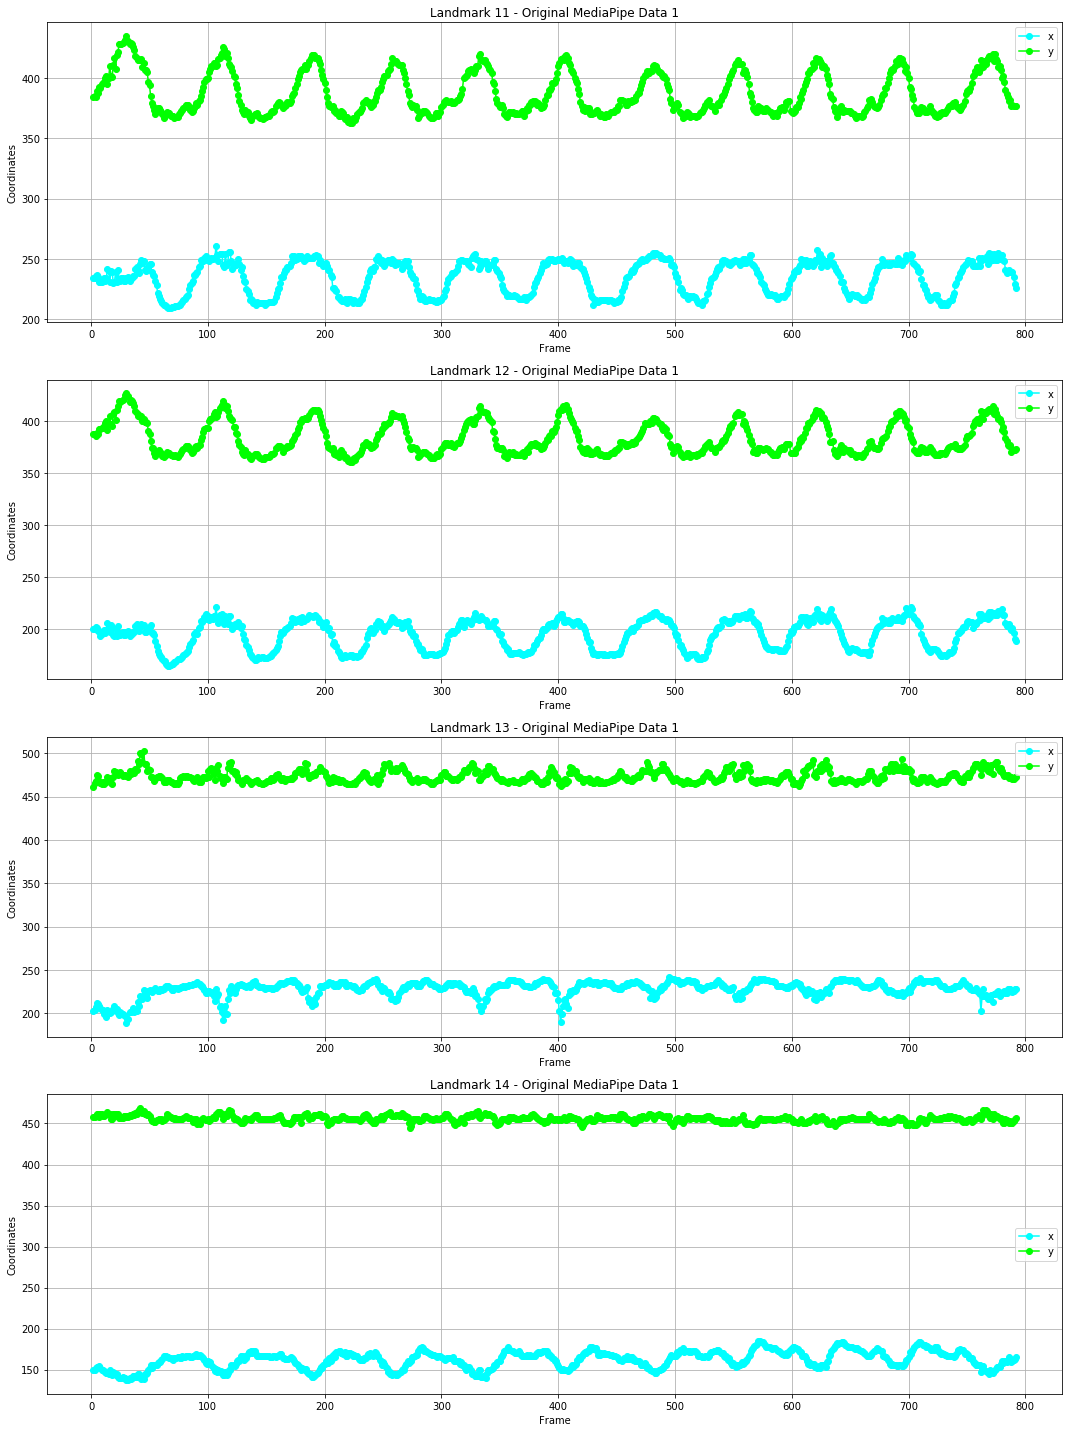

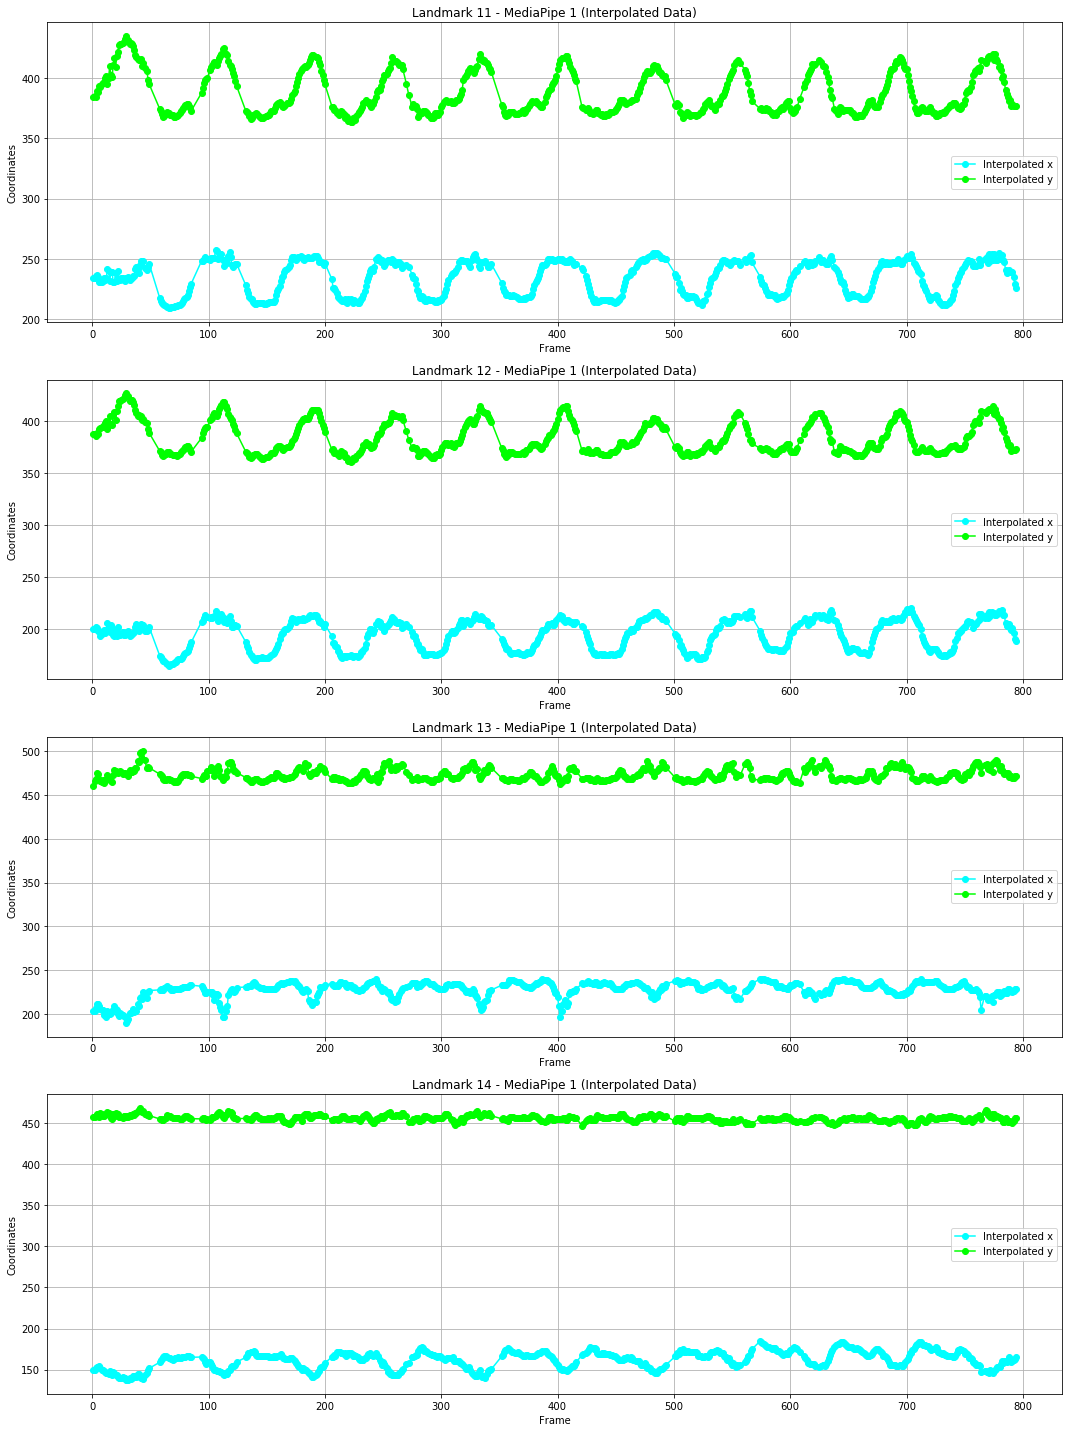

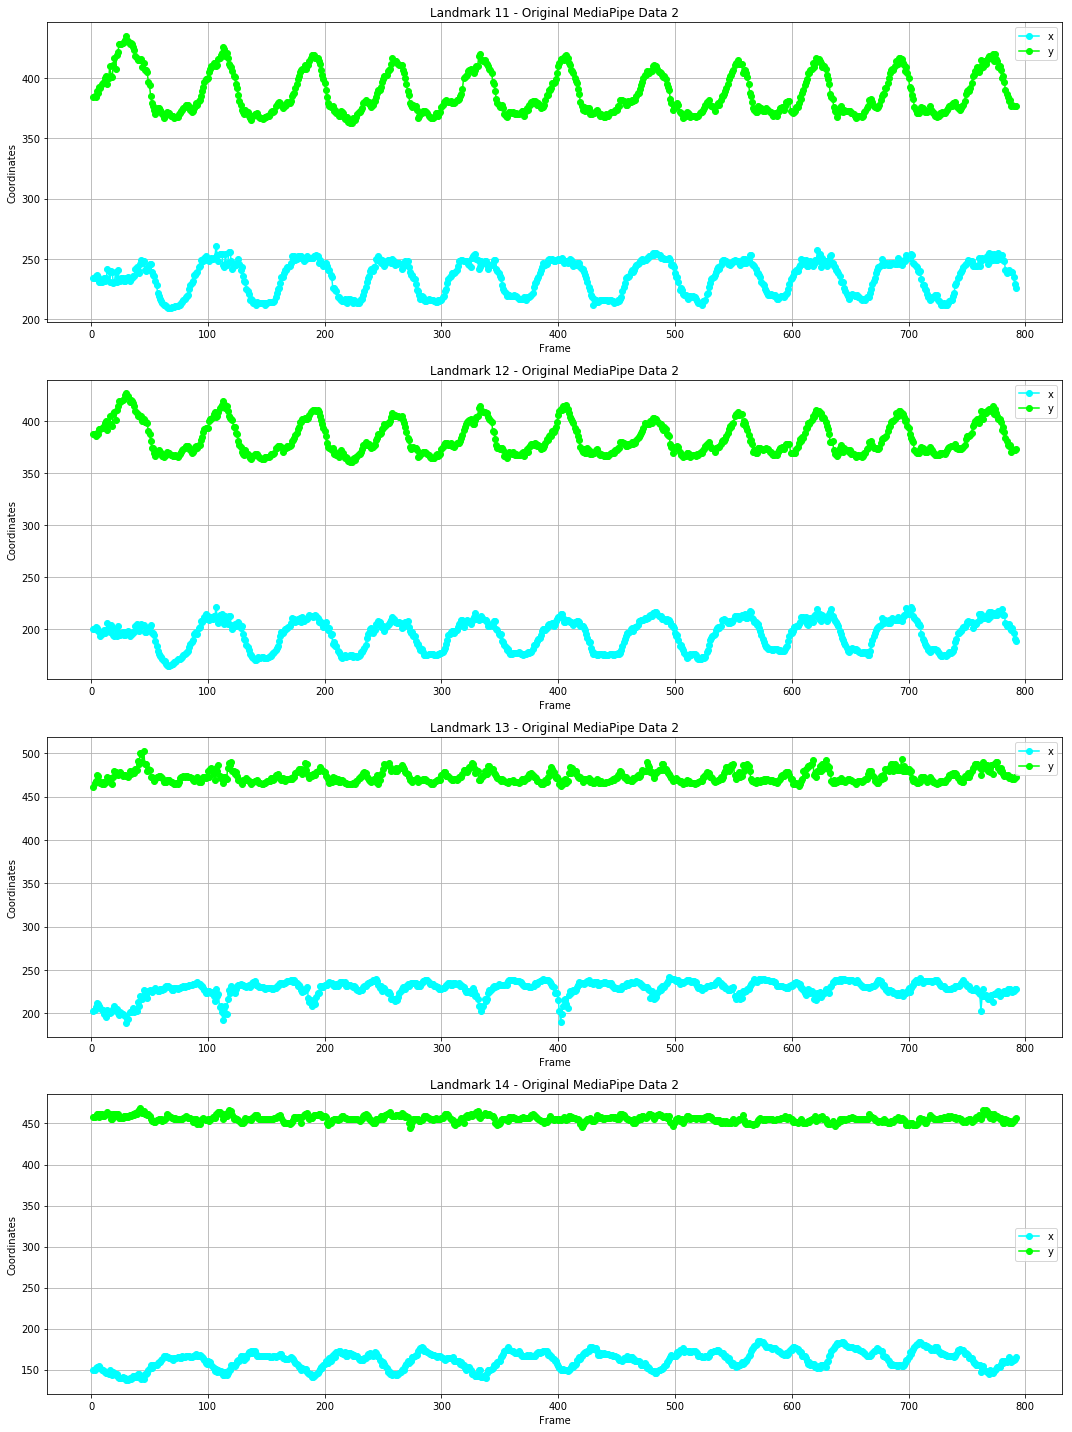

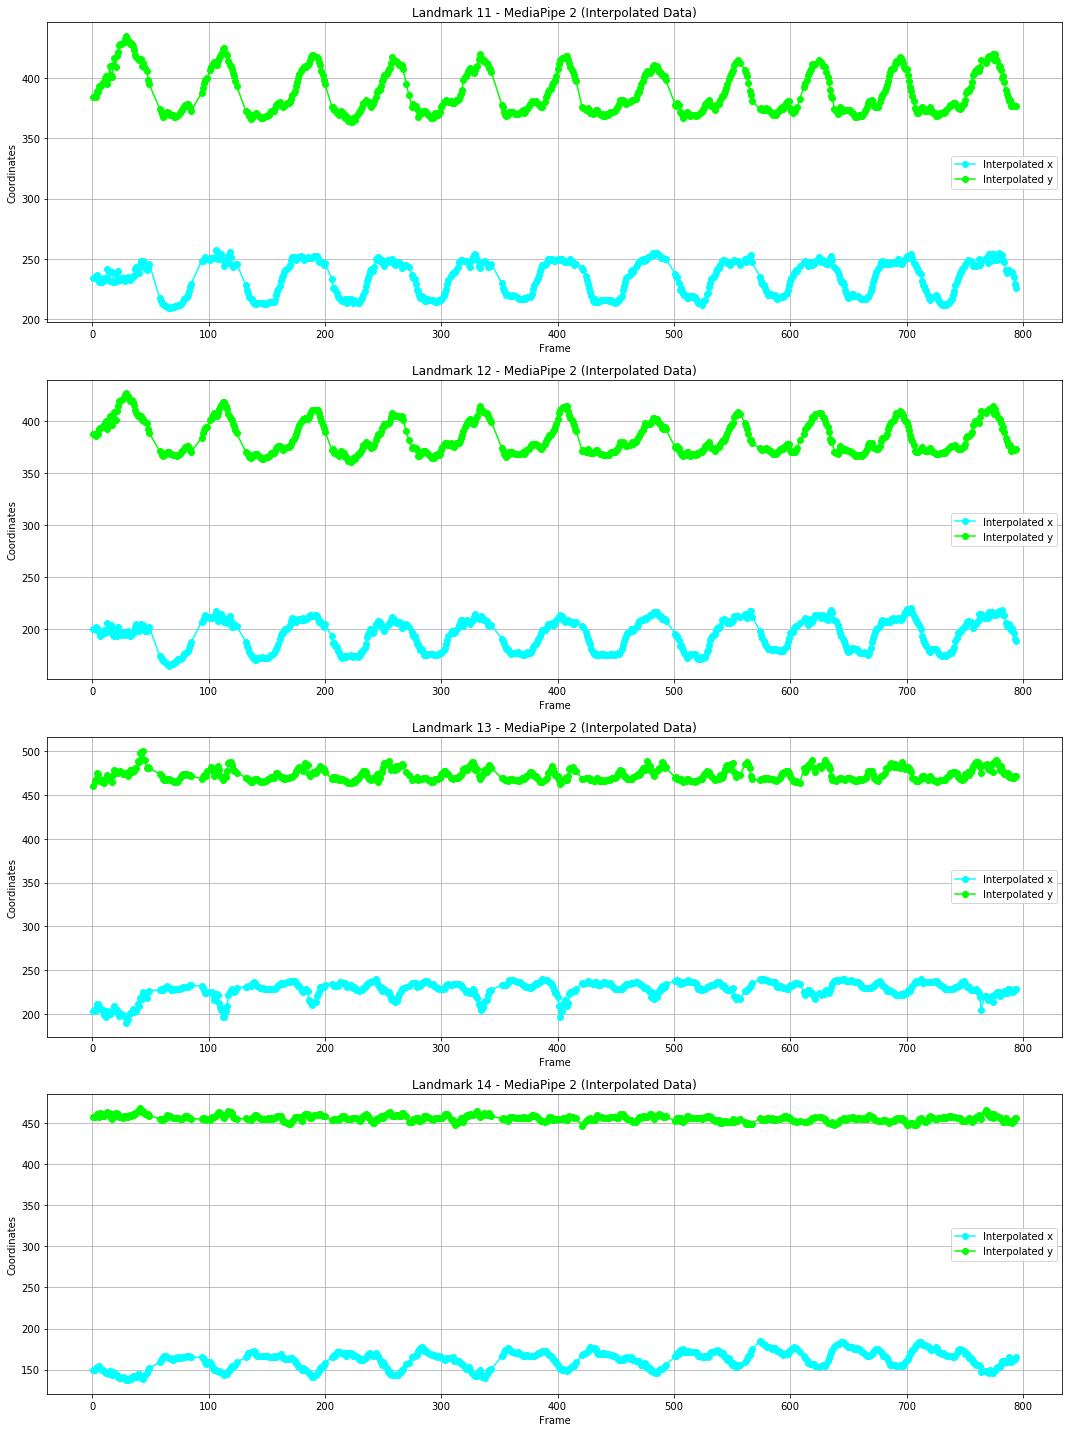

In [9]:
####這邊先把mediapipe資料內插成yolo的數量，因yolo資料量通常較長
###再將結果繪製出來檢查是否有對齊，且沒有失真
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

%matplotlib inline      
# 讀取 YOLO 的資料
yolo_data = np.loadtxt('yolo_coordinates_interpolated.txt', delimiter=',')
yolo_frames = yolo_data[:, 0]  # frame numbers

# 讀取第一份 MediaPipe 的資料
mediapipe_data_1 = np.loadtxt('mediapipe_landmarks_1st_interp.txt', delimiter=',')
landmarks_1 = np.unique(mediapipe_data_1[:, 1])  # unique landmark numbers

# 讀取第二份 MediaPipe 的資料
mediapipe_data_2 = np.loadtxt('mediapipe_landmarks_2_1st_interp.txt', delimiter=',')
landmarks_2 = np.unique(mediapipe_data_2[:, 1])  # unique landmark numbers

def interpolate_mediapipe(yolo_frames, mediapipe_data, landmarks):
    interpolated_data = []
    # original_data = []
    
    for landmark in landmarks:
        # 獲取該 landmark 的座標
        group = mediapipe_data[mediapipe_data[:, 1] == landmark]
        frames = group[:, 0]
        x_coords = group[:, 2]
        y_coords = group[:, 3]
#         z_coords = group[:, 4]

        # original_data.append((frames, x_coords, y_coords, z_coords))


        # 將 MediaPipe 的第一幀對應到 YOLO 的第一幀，最後一幀對應到 YOLO 的最後一幀
        mediapipe_first_frame = frames[0]
        mediapipe_last_frame = frames[-1]

        # 將 YOLO 的幀範圍內的第一幀和最後一幀對應到 MediaPipe 的幀範圍
        aligned_frames = np.linspace(yolo_frames[0], yolo_frames[-1], len(frames))

        # 使用 interp1d 進行內插

        interp_x = interp1d(aligned_frames, x_coords, kind='linear')
        interp_y = interp1d(aligned_frames, y_coords, kind='linear')
#         interp_z = interp1d(aligned_frames, z_coords, kind='linear')

        
        interp_x = interp1d(aligned_frames, x_coords, kind='linear', fill_value="extrapolate")
        interp_y = interp1d(aligned_frames, y_coords, kind='linear', fill_value="extrapolate")
#         interp_z = interp1d(aligned_frames, z_coords, kind='linear', fill_value="extrapolate")
        
        # 使用 YOLO 的幀數範圍內進行內插
        interpolated_x = interp_x(yolo_frames)
        interpolated_y = interp_y(yolo_frames)
#         interpolated_z = interp_z(yolo_frames)
        
        # 將內插的資料添加到列表中
        for i, frame in enumerate(yolo_frames):
            interpolated_data.append([frame, landmark, interpolated_x[i], interpolated_y[i]])
    
    return interpolated_data

# 處理第一份 MediaPipe 資料
interpolated_data_1 = interpolate_mediapipe(yolo_frames, mediapipe_data_1, landmarks_1)
# 處理第二份 MediaPipe 資料
interpolated_data_2 = interpolate_mediapipe(yolo_frames, mediapipe_data_2, landmarks_2)

# 將內插後的資料寫入 TXT 檔案
with open('interpolated_mediapipe_landmarks_1.txt', 'w') as f:
    for entry in interpolated_data_1:
        f.write(f"{entry[0]},{entry[1]},{entry[2]},{entry[3]}\n")

with open('interpolated_mediapipe_landmarks_2.txt', 'w') as f:
    for entry in interpolated_data_2:
        f.write(f"{entry[0]},{entry[1]},{entry[2]},{entry[3]}\n")

# 繪圖
def plot_mediapipe_landmarks(mediapipe_data, title):
    landmarks_to_plot = [11, 12, 13, 14]  # 只繪製這些 landmarks
    num_landmarks = len(landmarks_to_plot)

    # 創建子圖
    fig, axs = plt.subplots(num_landmarks, 1, figsize=(15, 5 * num_landmarks))

    for i, landmark in enumerate(landmarks_to_plot):
        # 選擇要繪製的 landmark 資料
        landmark_data = mediapipe_data[mediapipe_data[:, 1] == landmark]
        
        # 繪製 x, y, z 座標
        axs[i].plot(landmark_data[:, 0], landmark_data[:, 2], label='x', marker='o', color='cyan')
        axs[i].plot(landmark_data[:, 0], landmark_data[:, 3], label='y', marker='o', color='lime')
#         axs[i].plot(landmark_data[:, 0], landmark_data[:, 4], label='z', marker='o', color='orange')

        # 設定標題與標籤
        axs[i].set_title(f'Landmark {landmark} - {title}')
        axs[i].set_xlabel('Frame')
        axs[i].set_ylabel('Coordinates')
        axs[i].legend()
        axs[i].grid()

    plt.tight_layout()  # 自動調整子圖間距
    plt.show()

def plot_interpolated_landmarks(interpolated_data, title):
    landmarks_to_plot =[11, 12, 13, 14]  # 只繪製這些 landmarks
    num_landmarks = len(landmarks_to_plot)

    # 創建子圖
    fig, axs = plt.subplots(num_landmarks, 1, figsize=(15, 5 * num_landmarks))

    for i, landmark in enumerate(landmarks_to_plot):
        # 內插後資料
        interpolated_data_np = np.array(interpolated_data)
        interpolated_data_landmark = interpolated_data_np[interpolated_data_np[:, 1] == landmark]
        axs[i].plot(interpolated_data_landmark[:, 0], interpolated_data_landmark[:, 2], label='Interpolated x', marker='o', color='cyan')
        axs[i].plot(interpolated_data_landmark[:, 0], interpolated_data_landmark[:, 3], label='Interpolated y', marker='o', color='lime')
#         axs[i].plot(interpolated_data_landmark[:, 0], interpolated_data_landmark[:, 4], label='Interpolated z', marker='o', color='orange')

        axs[i].set_title(f'Landmark {landmark} - {title} (Interpolated Data)')
        axs[i].set_xlabel('Frame')
        axs[i].set_ylabel('Coordinates')
        axs[i].legend()
        axs[i].grid()

    plt.tight_layout()  # 自動調整子圖間距
    plt.show()

# 繪製第一份 MediaPipe 的原始資料和內插資料
plot_mediapipe_landmarks(mediapipe_data_1, 'Original MediaPipe Data 1')
plot_interpolated_landmarks(interpolated_data_1, 'MediaPipe 1')

# 繪製第二份 MediaPipe 的原始資料和內插資料
plot_mediapipe_landmarks(mediapipe_data_2, 'Original MediaPipe Data 2')
plot_interpolated_landmarks(interpolated_data_2, 'MediaPipe 2')


In [7]:
%cd D:\\labdata\\MOCAP\\recordings_copy\\師友人4\\recording_20241125_163535


D:\labdata\MOCAP\recordings_copy\師友人4\recording_20241125_163535


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\user\Anaconda3\lib\si

已完成內插並將結果儲存至 mediapipe_landmarks_1st_interp.txt
Skipping line: 46,no detection

Skipping line: 50,no detection

Skipping line: 51,no detection

Skipping line: 52,no detection

Skipping line: 53,no detection

Skipping line: 54,no detection

Skipping line: 55,no detection

Skipping line: 56,no detection

Skipping line: 57,no detection

Skipping line: 65,no detection

Skipping line: 86,no detection

Skipping line: 87,no detection

Skipping line: 88,no detection

Skipping line: 89,no detection

Skipping line: 90,no detection

Skipping line: 91,no detection

Skipping line: 92,no detection

Skipping line: 93,no detection

Skipping line: 100,no detection

Skipping line: 125,no detection

Skipping line: 126,no detection

Skipping line: 127,no detection

Skipping line: 128,no detection

Skipping line: 129,no detection

Skipping line: 130,no detection

Skipping line: 131,no detection

Skipping line: 168,no detection

Skipping line: 201,no detection

Skipping line: 202,no detection

Skipping line

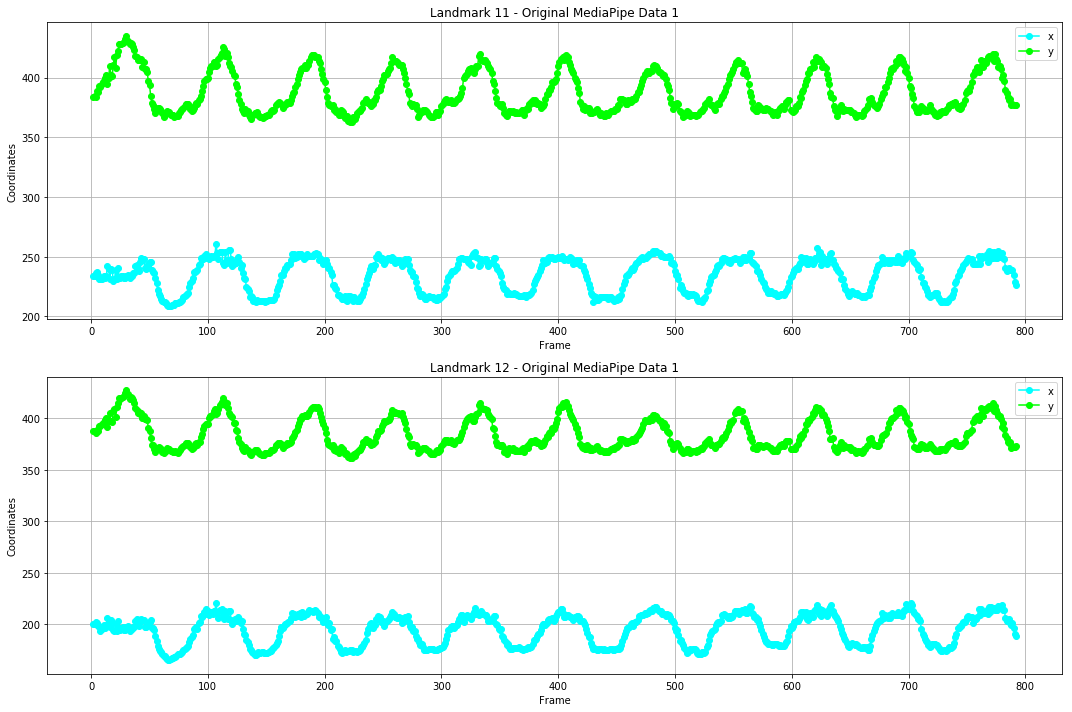

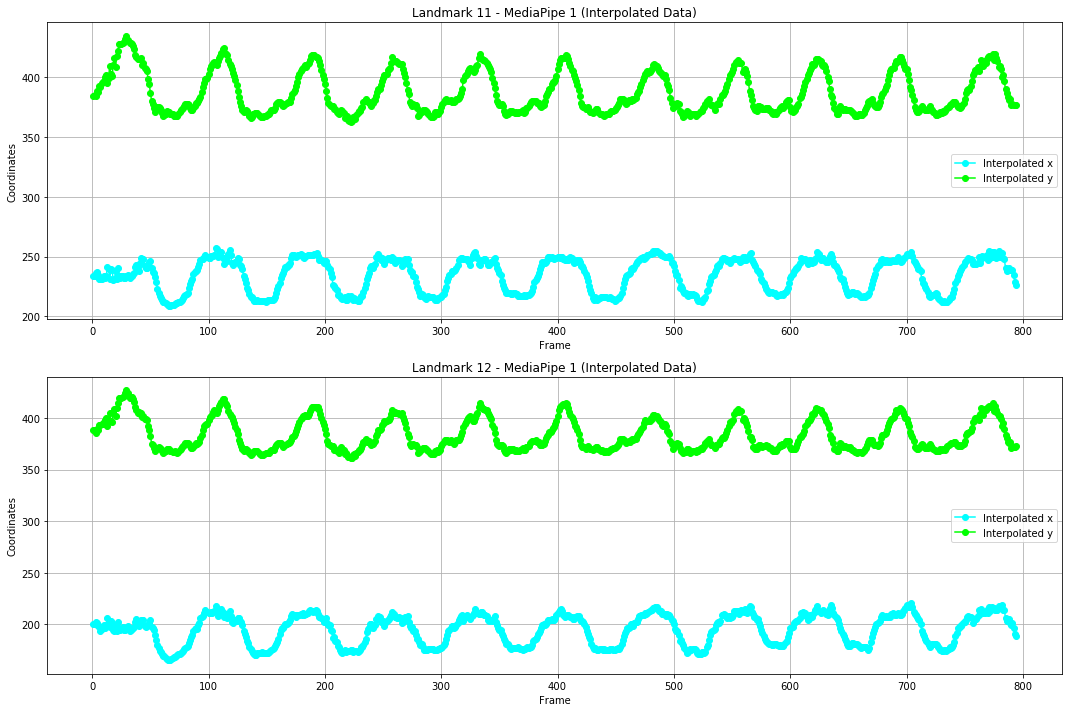

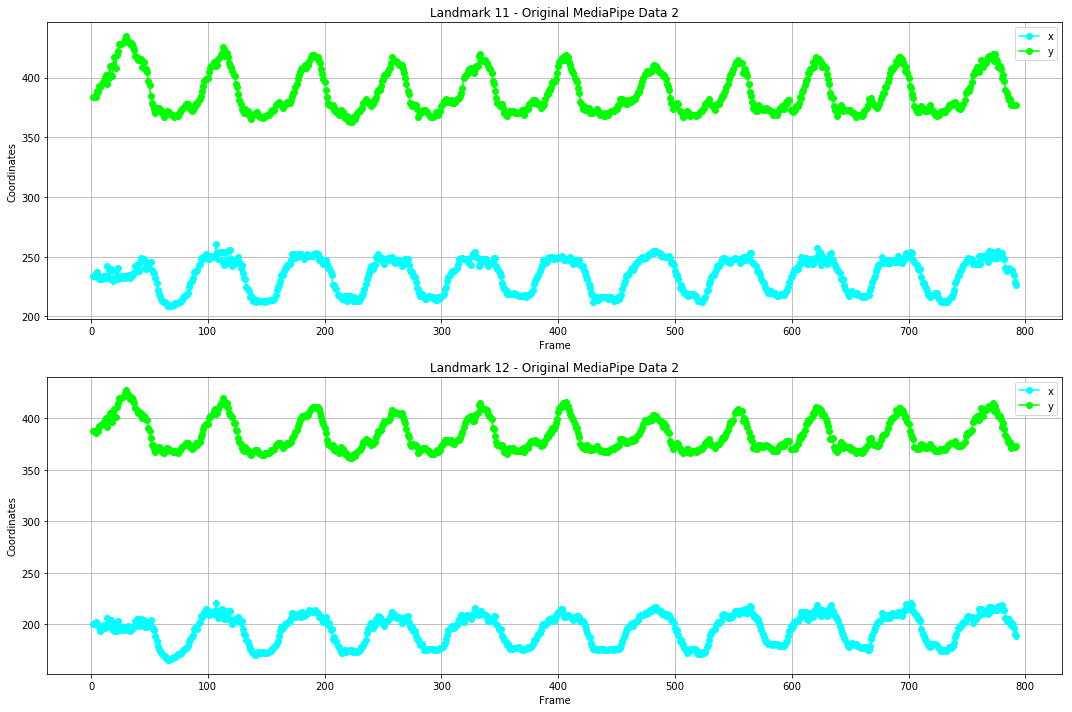

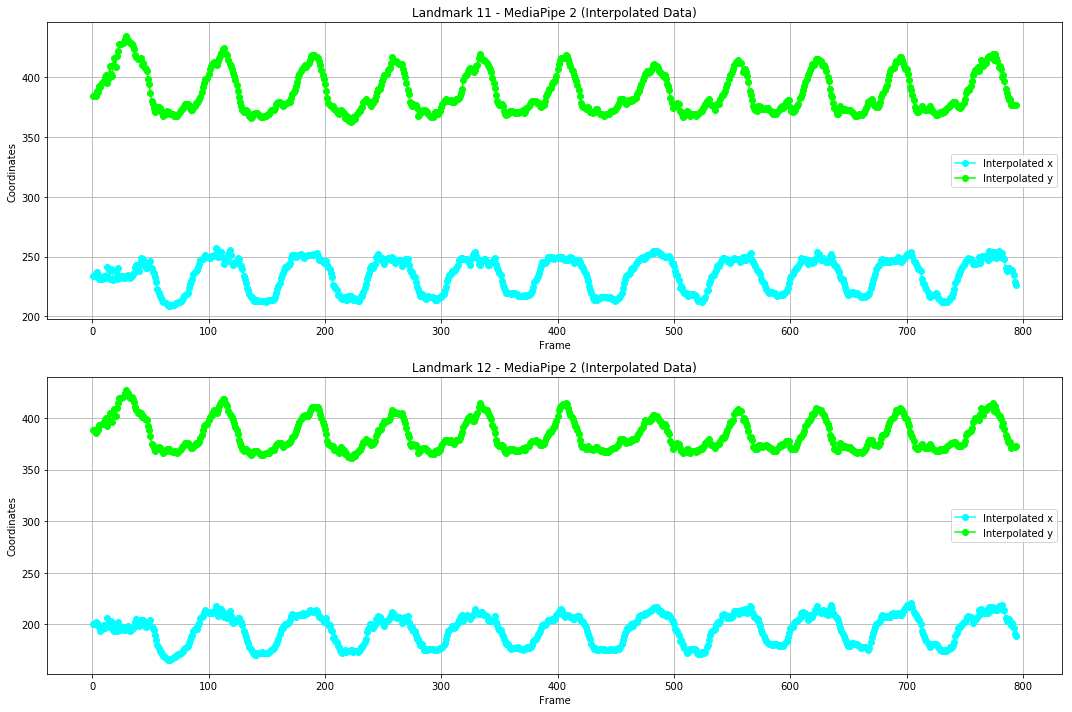

In [15]:
###寫一個把三次內插整合在一起的
#第一次:把mediapipe裡面沒偵測到的先內插補植
#第二次:把槓端的沒偵測到的內插補植
#第三次:把mediapipe資料的長度對齊yolo的長度

###處理mediapipe資料的no detection
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


def interpolate_landmarks(input_file, output_file):
    # 讀取TXT文件
    df = pd.read_csv(input_file, header=None, names=["frame", "landmark", "x", "y"])

    # 將 'no detection' 替換為 NaN
    df.replace('no detection', np.nan, inplace=True)

    # 將需要進行插值的列轉換為數值型
    df[['landmark', 'x', 'y']] = df[['landmark', 'x', 'y']].apply(pd.to_numeric, errors='coerce')

    # 取得所有 frame 的範圍
    all_frames = df['frame'].unique()

    # 準備一個空的列表來儲存最終結果
    interpolated_data = []

    # 對每個 frame 進行處理
    for frame in all_frames:
        current_frame_data = df[df['frame'] == frame]

        # 儲存該 frame 的所有資料
        if current_frame_data.empty:
            continue  # 如果沒有資料則跳過

        if 'no detection' in current_frame_data.values:
            # 如果有 'no detection' 的標記，儲存該行
            for landmark in range(0, 17):
                interpolated_data.append([frame, landmark, np.nan, np.nan])
            continue

        # 對 landmarks 11 到 24 進行插值
        for landmark in range(0, 17):
            landmark_data = current_frame_data[current_frame_data['landmark'] == landmark]

            if landmark_data.empty:
                # 如果當前 landmark 沒有資料，則進行內插
                prev_frame_data = df[(df['frame'] < frame) & (df['landmark'] == landmark)].iloc[-1] if not df[(df['frame'] < frame) & (df['landmark'] == landmark)].empty else None
                next_frame_data = df[(df['frame'] > frame) & (df['landmark'] == landmark)].iloc[0] if not df[(df['frame'] > frame) & (df['landmark'] == landmark)].empty else None
                
                if prev_frame_data is not None and next_frame_data is not None:
                    interp_x = (prev_frame_data['x'] + next_frame_data['x']) / 2
                    interp_y = (prev_frame_data['y'] + next_frame_data['y']) / 2
#                     interp_z = (prev_frame_data['z'] + next_frame_data['z']) / 2
                elif prev_frame_data is not None:
                    interp_x = prev_frame_data['x']
                    interp_y = prev_frame_data['y']
#                     interp_z = prev_frame_data['z']
                elif next_frame_data is not None:
                    interp_x = next_frame_data['x']
                    interp_y = next_frame_data['y']
#                     interp_z = next_frame_data['z']
                else:
                    interp_x = interp_y = interp_z = np.nan
                
                interpolated_data.append([frame, landmark, interp_x, interp_y])
            else:
                # 如果有資料，則直接取用
                landmark_row = landmark_data.iloc[0]
                interpolated_data.append([frame, landmark_row['landmark'], landmark_row['x'], landmark_row['y']])

    # 將結果轉換為 DataFrame
    output_df = pd.DataFrame(interpolated_data, columns=["frame", "landmark", "x", "y"])

    # 將結果保存到新的TXT文件，不輸出索引與標題行
    output_df.to_csv(output_file, index=False, header=False)

    print(f"已完成內插並將結果儲存至 {output_file}")

# 設定要處理的文件
input_files = ['mediapipe_landmarks.txt']  # 請替換為你的輸入檔名
output_files = ['mediapipe_landmarks_1st_interp.txt']  # 對應的輸出檔名

# 對每個文件進行內插處理
for input_file, output_file in zip(input_files, output_files):
    interpolate_landmarks(input_file, output_file)

####處理yolo的no detection並且內插


def load_yolo_data(filename):
    # 讀取 YOLO 資料
    data = []
    with open(filename, 'r') as f:
        for line in f:
            try:
                values = [float(x) for x in line.strip().split(',')]
                if len(values) == 5:  # YOLO 的資料應有 5 個欄位
                    data.append(values)
            except ValueError:
                print(f"Skipping line: {line}")
    return np.array(data)


def interpolate_missing_detections(yolo_data):
    frames = yolo_data[:, 0]
    x_center = yolo_data[:, 1]
    y_center = yolo_data[:, 2]
    widths = yolo_data[:, 3]
    heights = yolo_data[:, 4]

    # 找到有效檢測的幀索引
    valid_indices = np.where((x_center != -1) & (y_center != -1) & (widths != -1) & (heights != -1))[0]

    # 確保所有幀都有值
    all_frames = np.arange(int(frames.min()), int(frames.max()) + 1)

    # 使用有效檢測的幀進行插值
    interp_x_center = interp1d(frames[valid_indices], x_center[valid_indices], kind='linear', fill_value="extrapolate")
    interp_y_center = interp1d(frames[valid_indices], y_center[valid_indices], kind='linear', fill_value="extrapolate")
    interp_widths = interp1d(frames[valid_indices], widths[valid_indices], kind='linear', fill_value="extrapolate")
    interp_heights = interp1d(frames[valid_indices], heights[valid_indices], kind='linear', fill_value="extrapolate")

    # 對於所有幀進行插值
    interpolated_x_center = interp_x_center(all_frames)
    interpolated_y_center = interp_y_center(all_frames)
    interpolated_widths = interp_widths(all_frames)
    interpolated_heights = interp_heights(all_frames)

    # 組合內插後的資料
    interpolated_data = np.column_stack((all_frames, interpolated_x_center, interpolated_y_center, interpolated_widths, interpolated_heights))
    return interpolated_data

# 載入 YOLO 資料
yolo_data = load_yolo_data('yolo_coordinates.txt')

# 內插 YOLO 中的 "no detection" 資料
interpolated_yolo_data = interpolate_missing_detections(yolo_data)

# 將結果保存到新的檔案，第一列為整數，其他為浮點數
np.savetxt('yolo_coordinates_interpolated.txt', interpolated_yolo_data, delimiter=',', fmt='%d,%.8f,%.8f,%.8f,%.8f')

print("YOLO 'no detection' frames have been interpolated and saved to 'yolo_coordinates_interpolated.txt'.")

####這邊先把mediapipe資料內插成yolo的數量，因yolo資料量通常較長

%matplotlib inline      
# 讀取 YOLO 的資料
yolo_data = np.loadtxt('yolo_coordinates_interpolated.txt', delimiter=',')
yolo_frames = yolo_data[:, 0]  # frame numbers

# 讀取第一份 MediaPipe 的資料
mediapipe_data_1 = np.loadtxt('mediapipe_landmarks_1st_interp.txt', delimiter=',')
landmarks_1 = np.unique(mediapipe_data_1[:, 1])  # unique landmark numbers

# 讀取第二份 MediaPipe 的資料
# mediapipe_data_2 = np.loadtxt('mediapipe_landmarks_2_1st_interp.txt', delimiter=',')
# landmarks_2 = np.unique(mediapipe_data_2[:, 1])  # unique landmark numbers

def interpolate_mediapipe(yolo_frames, mediapipe_data, landmarks):
    interpolated_data = []
    # original_data = []
    
    for landmark in landmarks:
        # 獲取該 landmark 的座標
        group = mediapipe_data[mediapipe_data[:, 1] == landmark]
        frames = group[:, 0]
        x_coords = group[:, 2]
        y_coords = group[:, 3]
#         z_coords = group[:, 4]

        # original_data.append((frames, x_coords, y_coords, z_coords))


        # 將 MediaPipe 的第一幀對應到 YOLO 的第一幀，最後一幀對應到 YOLO 的最後一幀
        mediapipe_first_frame = frames[0]
        mediapipe_last_frame = frames[-1]

        # 將 YOLO 的幀範圍內的第一幀和最後一幀對應到 MediaPipe 的幀範圍
        aligned_frames = np.linspace(yolo_frames[0], yolo_frames[-1], len(frames))

        # 使用 interp1d 進行內插

        interp_x = interp1d(aligned_frames, x_coords, kind='linear')
        interp_y = interp1d(aligned_frames, y_coords, kind='linear')
#         interp_z = interp1d(aligned_frames, z_coords, kind='linear')

        
        interp_x = interp1d(aligned_frames, x_coords, kind='linear', fill_value="extrapolate")
        interp_y = interp1d(aligned_frames, y_coords, kind='linear', fill_value="extrapolate")
#         interp_z = interp1d(aligned_frames, z_coords, kind='linear', fill_value="extrapolate")
        
        # 使用 YOLO 的幀數範圍內進行內插
        interpolated_x = interp_x(yolo_frames)
        interpolated_y = interp_y(yolo_frames)
#         interpolated_z = interp_z(yolo_frames)
        
        # 將內插的資料添加到列表中
        for i, frame in enumerate(yolo_frames):
            interpolated_data.append([frame, landmark, interpolated_x[i], interpolated_y[i]])
    
    return interpolated_data

# 處理第一份 MediaPipe 資料
interpolated_data_1 = interpolate_mediapipe(yolo_frames, mediapipe_data_1, landmarks_1)
# 處理第二份 MediaPipe 資料
interpolated_data_2 = interpolate_mediapipe(yolo_frames, mediapipe_data_2, landmarks_2)

# 將內插後的資料寫入 TXT 檔案
with open('interpolated_mediapipe_landmarks_1.txt', 'w') as f:
    for entry in interpolated_data_1:
        f.write(f"{entry[0]},{entry[1]},{entry[2]},{entry[3]}\n")

# with open('interpolated_mediapipe_landmarks_2.txt', 'w') as f:
#     for entry in interpolated_data_2:
#         f.write(f"{entry[0]},{entry[1]},{entry[2]},{entry[3]}\n")

# 繪圖
def plot_mediapipe_landmarks(mediapipe_data, title):
    landmarks_to_plot = [11,12]  # 只繪製這些 landmarks
    num_landmarks = len(landmarks_to_plot)

    # 創建子圖
    fig, axs = plt.subplots(num_landmarks, 1, figsize=(15, 5 * num_landmarks))

    for i, landmark in enumerate(landmarks_to_plot):
        # 選擇要繪製的 landmark 資料
        landmark_data = mediapipe_data[mediapipe_data[:, 1] == landmark]
        
        # 繪製 x, y, z 座標
        axs[i].plot(landmark_data[:, 0], landmark_data[:, 2], label='x', marker='o', color='cyan')
        axs[i].plot(landmark_data[:, 0], landmark_data[:, 3], label='y', marker='o', color='lime')
#         axs[i].plot(landmark_data[:, 0], landmark_data[:, 4], label='z', marker='o', color='orange')

        # 設定標題與標籤
        axs[i].set_title(f'Landmark {landmark} - {title}')
        axs[i].set_xlabel('Frame')
        axs[i].set_ylabel('Coordinates')
        axs[i].legend()
        axs[i].grid()

    plt.tight_layout()  # 自動調整子圖間距
    plt.show()

def plot_interpolated_landmarks(interpolated_data, title):
    landmarks_to_plot = [11,12]  # 只繪製這些 landmarks
    num_landmarks = len(landmarks_to_plot)

    # 創建子圖
    fig, axs = plt.subplots(num_landmarks, 1, figsize=(15, 5 * num_landmarks))

    for i, landmark in enumerate(landmarks_to_plot):
        # 內插後資料
        interpolated_data_np = np.array(interpolated_data)
        interpolated_data_landmark = interpolated_data_np[interpolated_data_np[:, 1] == landmark]
        axs[i].plot(interpolated_data_landmark[:, 0], interpolated_data_landmark[:, 2], label='Interpolated x', marker='o', color='cyan')
        axs[i].plot(interpolated_data_landmark[:, 0], interpolated_data_landmark[:, 3], label='Interpolated y', marker='o', color='lime')
#         axs[i].plot(interpolated_data_landmark[:, 0], interpolated_data_landmark[:, 4], label='Interpolated z', marker='o', color='orange')

        axs[i].set_title(f'Landmark {landmark} - {title} (Interpolated Data)')
        axs[i].set_xlabel('Frame')
        axs[i].set_ylabel('Coordinates')
        axs[i].legend()
        axs[i].grid()

    plt.tight_layout()  # 自動調整子圖間距
    plt.show()

# 繪製第一份 MediaPipe 的原始資料和內插資料
plot_mediapipe_landmarks(mediapipe_data_1, 'Original MediaPipe Data 1')
plot_interpolated_landmarks(interpolated_data_1, 'MediaPipe 1')

# 繪製第二份 MediaPipe 的原始資料和內插資料
plot_mediapipe_landmarks(mediapipe_data_2, 'Original MediaPipe Data 2')
plot_interpolated_landmarks(interpolated_data_2, 'MediaPipe 2')

